**<div align="right">Instituto Nacional de Pesquisa Espacial (INPE) - 2020</div>**

**<div align="right">Disciplina: SER-347</div>**
***

## Projeto 9
***

# Detecção de nuvens e sombra de nuvens:

## Informação espectral e metadados
***
#### Alunos
* Aline Casassola 
* Felipe Rafael de Sá Menezes Lucena
* Grazieli Rodigheri

### Importação das bibliotecas usadas

In [1]:
# Importa a gdal, ogr e osr
from osgeo import gdal, ogr, osr

# Importa *
from gdalconst import *

# Uso de exceções
gdal.UseExceptions()

# Importa o matplotlib
import matplotlib.pyplot as plt

# Importa o Numpy
import numpy as np

# Importa os widgets
import ipywidgets as widgets

#Importa shape e mapping
from shapely.geometry import shape, mapping

import fiona
import math
import xml.etree.ElementTree as ET
import os

### Função que abre e retorna a imagem NIR do CBERS para calcular a máscara de nuvens:

In [2]:
# Função para abrir dataset:
def abrir_dataset (nome_arquivo):
    print ("Abrindo o arquivo: " + nome_arquivo)
    
    # Tenta abrir a imagem
    dataset = None
    try:
        dataset = gdal.Open(nome_arquivo, GA_ReadOnly)
        print("Arquivo aberto com sucesso!")
    except:
        print("Erro na abertura do arquivo!")
    
    return dataset

### Seleção da imagem pelo usuário

In [4]:
cenas = []
for i in os.listdir("../imagens/"):
    if '.' not in i:
        cenas.append("../imagens/"+i)
        
# Cria um dropdown com a lista de imagens
cena_folder = widgets.Dropdown(options = cenas)

print ("Selecione a pasta da imagem")
cena_folder

Selecione a pasta da imagem


Dropdown(options=('../imagens/CBERS_4_MUX_20200605_165_117_L4', '../imagens/CBERS_4_MUX_20200606_156_109_L2'),…

In [5]:
bandas = []
values = []
for i in os.listdir(str(cena_folder.value)):
    if '.' not in i:
        values.append(i)
        
for i in values:
    bandas.append(('Banda ' + i[-1], cena_folder.value + '/' + i +"/"+ i[-14:] +".tif"))
        
# Cria um dropdown com a lista de imagens
bandas_folder = widgets.ToggleButtons(
    options=bandas,
    description='Selecione:',
    disabled=False,
    button_style=''
)

bandas_folder

ToggleButtons(description='Selecione:', options=(('Banda 5', '../imagens/CBERS_4_MUX_20200606_156_109_L2/20060…

### Abertura do dataset e conversão da banda NIR para array

In [6]:
# Abre a imagem NIR:
raster_NIR = abrir_dataset(bandas_folder.value)

# Obtém a banda única do dataset
banda_NIR = raster_NIR.GetRasterBand(1)

# Transforma a banda em array
array_banda_NIR = banda_NIR.ReadAsArray()

Abrindo o arquivo: ../imagens/CBERS_4_MUX_20200606_156_109_L2/200606_BAND8/200606_BAND8.tif
Arquivo aberto com sucesso!


## Máscara de nuvens

### Seleção do limiar pelo usuário

In [7]:
limiar = widgets.IntSlider( min=0, max=255, value=120, step=1)

print("Selecione um limiar (DN)")
limiar

Selecione um limiar (DN)


IntSlider(value=120, max=255)

### Geração da máscara de nuvens

In [8]:
# Cria uma cópia da banda NIR para trabalhar
mascara_nuvens = np.copy(array_banda_NIR)

# Cria a máscara em função do limiar
mascara_nuvens[mascara_nuvens < limiar.value] = False
mascara_nuvens[mascara_nuvens >= limiar.value] = True

### Mínimos e máximos dos pixels

In [9]:
print("Valores banda NIR:")
print("Min: ", array_banda_NIR.min())
print("Max: ", array_banda_NIR.max())
print("")

print("Valores máscara de Núvens:")
print("Min: ", mascara_nuvens.min())
print("Max: ", mascara_nuvens.max())
print("")

Valores banda NIR:
Min:  0
Max:  222

Valores máscara de Núvens:
Min:  0
Max:  1



### Apresenta as imagens

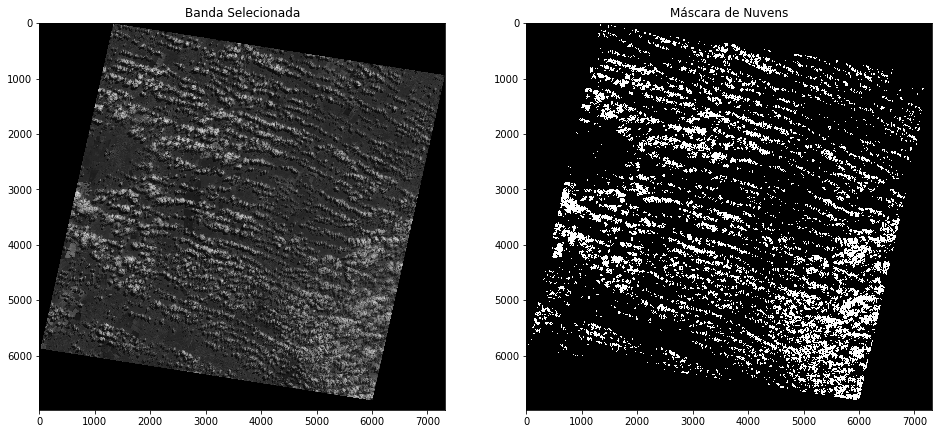

In [10]:
# Cria a figura
plt.figure(figsize = (16, 8))

# Mostra a imagem NIR
plt.subplot(121)
plt.title("Banda Selecionada")
plt.imshow(array_banda_NIR, cmap='gray');

# Mostra a máscara de nuvens
plt.subplot(122)
plt.title("Máscara de Nuvens")
plt.imshow(mascara_nuvens, cmap='gray');

## Estatísticas

### Estatísticas da imagem inteira

In [11]:
num_total_pixels = mascara_nuvens.size
print ("Número total de pixels:", num_total_pixels)

num_pixels_nuvem = len(mascara_nuvens[mascara_nuvens == 1])
print ("Número total de pixels com nuvens:", num_pixels_nuvem)

per_pixels_nuvem = (num_pixels_nuvem/num_total_pixels)*100
# per_pixels_nuvem = 80
print ("Percentual de pixels com nuvens:", (round(per_pixels_nuvem, 3)))

print ("\nClassificação da imagem de acordo com o percentual de nuvens: ")
if (per_pixels_nuvem > 75):
    print("Céu totalmente coberto")
elif (per_pixels_nuvem > 20):
    print("Céu parcialmente coberto")
else:
    print("Céu limpo")

Número total de pixels: 51050025
Número total de pixels com nuvens: 6553771
Percentual de pixels com nuvens: 12.838

Classificação da imagem de acordo com o percentual de nuvens: 
Céu limpo


### Estatísticas por quadrantes

In [12]:
# Obtém a metade da linha e da coluna:
meio_linhas = int(np.size(mascara_nuvens,0)/2)
meio_colunas = int(np.size(mascara_nuvens,1)/2)

# Obtém o array de cada quadrante:
Q1 = mascara_nuvens[:meio_linhas, :meio_colunas]
Q2 = mascara_nuvens[:meio_linhas, meio_colunas:]
Q3 = mascara_nuvens[meio_linhas:, :meio_colunas]
Q4 = mascara_nuvens[meio_linhas:, meio_colunas:]

# Quadrante 1:
total_pixels_Q1 = Q1.size
pixels_nuvem_Q1 = len(Q1[Q1 == 1])
per_nuvem_Q1 = (pixels_nuvem_Q1/total_pixels_Q1)*100
print ("Percentual de pixels com nuvens no Q1: ", (round(per_nuvem_Q1, 2)), "%", sep='')

# Quadrante 2:
total_pixels_Q2 = Q2.size
pixels_nuvem_Q2 = len(Q2[Q2 == 1])
per_nuvem_Q2 = (pixels_nuvem_Q2/total_pixels_Q2)*100
print ("Percentual de pixels com nuvens no Q2: ", (round(per_nuvem_Q2, 2)), "%", sep='')

# Quadrante 3:
total_pixels_Q3 = Q3.size
pixels_nuvem_Q3 = len(Q3[Q3 == 1])
per_nuvem_Q3 = (pixels_nuvem_Q3/total_pixels_Q3)*100
print ("Percentual de pixels com nuvens no Q3: ", (round(per_nuvem_Q3, 2)), "%", sep='')

# Quadrante 4:
total_pixels_Q4 = Q4.size
pixels_nuvem_Q4 = len(Q4[Q4 == 1])
per_nuvem_Q4 = (pixels_nuvem_Q4/total_pixels_Q4)*100
print ("Percentual de pixels com nuvens no Q4: ", (round(per_nuvem_Q4, 2)), "%", sep='')

Percentual de pixels com nuvens no Q1: 13.21%
Percentual de pixels com nuvens no Q2: 9.33%
Percentual de pixels com nuvens no Q3: 10.2%
Percentual de pixels com nuvens no Q4: 18.61%


## Salvando a máscara como arquivo tif

In [13]:
def save_mask(matriz_de_pixels, nome_do_arquivo, dataset_de_referencia):
    # Obtém as informações de tamanho do raster de referência
    linhas = dataset_de_referencia.RasterYSize
    colunas = dataset_de_referencia.RasterXSize
    bandas = 1
        
    # Carrega o driver para salvar tif
    driver = gdal.GetDriverByName('GTiff')
    
    # Obtém o tipo de dado do dataset de referência
    data_type = dataset_de_referencia.GetRasterBand(1).DataType
    
    # Criar novo dataset
    dataset_output = driver.Create(nome_do_arquivo, colunas, linhas, bandas, data_type)
    
    # Copiar informações espaciais da banda já existente
    dataset_output.SetGeoTransform(dataset_de_referencia.GetGeoTransform())
    
    # Copiar informações de projeção
    dataset_output.SetProjection(dataset_de_referencia.GetProjectionRef())
    
    # Escrever dados da matriz NumPy na banda
    dataset_output.GetRasterBand(1).WriteArray(matriz_de_pixels)
    
    # Salvar valores
    dataset_output.FlushCache()
    
    # Fechar dataset
    dataset_output = None

In [14]:
# Nome do arquivo de saída
nome_arquivo_mascara_destino = '../produtos/imagens/mascara_nuvens_' + bandas_folder.value[-16:]

# Chama a função para salvar a máscara de nuvens
save_mask(mascara_nuvens,nome_arquivo_mascara_destino,raster_NIR)

## Máscara de sombras
### Abrindo a máscara de nuvens

In [15]:
# Abre a mascara de nuvem gerada anteriormente
print ("Abrindo o arquivo: " + nome_arquivo_mascara_destino)

# Tenta abrir a imagem
try:
    mascara_nuvens = gdal.Open(nome_arquivo_mascara_destino, GA_ReadOnly)
    print("Arquivo aberto com sucesso!")
except:
    print("Erro na abertura do arquivo!")

Abrindo o arquivo: ../produtos/imagens/mascara_nuvens_200606_BAND8.tif
Arquivo aberto com sucesso!


In [16]:
# Obtém a banda única do dataset
banda_mascara = mascara_nuvens.GetRasterBand(1)

### Gerando a máscara de sombras inicial (vetorização da máscara de nuvens)

In [17]:
srs = osr.SpatialReference()
srs.ImportFromWkt(mascara_nuvens.GetProjectionRef())

shp_layername_cloud = '../produtos/shp/mascara_nuvens_' + bandas_folder.value[-16:-4]
driver = ogr.GetDriverByName("ESRI Shapefile")   
shp_datasource = driver.CreateDataSource(shp_layername_cloud + '.shp')
shp_layer = shp_datasource.CreateLayer(shp_layername_cloud, srs=srs)

new_field = ogr.FieldDefn('DN', ogr.OFTReal)
shp_layer.CreateField(new_field) 


gdal.Polygonize(banda_mascara, banda_mascara, shp_layer, 0, [], callback=None)

shp_datasource.Destroy()
shp_layername_cloud = shp_layername_cloud + ".shp"

### Deslocamento da máscara de nuvens a partir de um delta_x e delta_y

![SegmentLocal](../apresentacao/deslocamento_sombra.gif "segment")

### Delta a partir dos metadados

![SegmentLocal](../apresentacao/metadados.jpg "segment")

In [18]:
tree = ET.parse(bandas_folder.value[:-3]+'xml')
root = tree.getroot()

sun_incidence = root.find("{http://www.gisplan.com.br/xmlsat}sunIncidenceAngle")
degree_sun_incidence = int(sun_incidence.find('{http://www.gisplan.com.br/xmlsat}degree').text)
minute_sun_incidence = int(sun_incidence.find('{http://www.gisplan.com.br/xmlsat}minute').text)
second_sun_incidence = int(sun_incidence.find('{http://www.gisplan.com.br/xmlsat}second').text)

sun_incidence = degree_sun_incidence + minute_sun_incidence/60 + second_sun_incidence/3600

image = root.find("{http://www.gisplan.com.br/xmlsat}image")
sun_position = image.find('{http://www.gisplan.com.br/xmlsat}sunPosition')
sun_azim = float(sun_position.find('{http://www.gisplan.com.br/xmlsat}sunAzimuth').text)
sun_zenith = float(sun_position.find('{http://www.gisplan.com.br/xmlsat}elevation').text)

sun_azim = math.radians(sun_azim)
sun_zenith = math.radians(sun_zenith)
view_azim = math.radians(0)
view_zenith = math.radians(0)

sen_sun_azi = math.sin(sun_azim)
cos_sun_azi = math.cos(sun_azim)
sen_view_azi = math.sin(view_azim)
cos_view_azi = math.cos(view_azim)
tan_sun_zenith = math.tan(sun_zenith)
tan_view_zenith = math.tan(view_zenith)

shadow_direction = math.pi + math.atan(sen_sun_azi*tan_sun_zenith-sen_view_azi*tan_view_zenith/
                                       (cos_sun_azi*tan_sun_zenith-cos_view_azi*tan_view_zenith))

h = 1500 #Altura das nuvens

shadow_distance = h * math.tan(math.radians(sun_incidence))

# shadow_distance2 = h * math.sqrt(
#     ( (sen_sun_azi*tan_sun_zenith) - (sen_view_azi*tan_view_zenith) )**2 +
#     ( (cos_sun_azi*tan_sun_zenith) - (cos_view_azi*tan_view_zenith) )**2
#     )

delta = (shadow_distance*math.sin(shadow_direction), shadow_distance*math.cos(shadow_direction))

\begin{equation} {\phi _s} = \pi + \arctan \left({\frac{{\sin {\phi _s}\tan {\theta _s} - \sin {\phi _v}\tan {\theta _v}}}{{\cos {\phi _s}\tan {\theta _s} - \cos {\phi _v}\tan {\theta _v}}}} \right) \end{equation}
<br/>
<center>B. Zhong et al. (2017)</center>
<br/>
\begin{equation} {d _s} = h * \tan(\Theta _s) \end{equation}

### Deslocamento da máscara

In [19]:
# Essas três funções realizam o deslocamento das feições da camada. (Elas são recursivas entre si)
def movePoint_Coords(coords, delta):     # "delta" é uma tupla (delta_x, delta_y)
    return tuple(c + d for c, d in zip(coords, delta))
def moveLine_Coords(coords, delta):
    return list(movePoint_Coords(pt_coords, delta) for pt_coords in coords)
def movePolygon_Coords(coords, delta):
    return list(moveLine_Coords(ring_coords, delta) for ring_coords in coords)

with fiona.open(shp_layername_cloud, "r") as shadow_cloud:

    with fiona.open("../produtos/shp/mascara_sombra_deslocada.shp", 
                    "w",
                    driver=shadow_cloud.driver,
                    schema=shadow_cloud.schema,
                    crs=shadow_cloud.crs) as moved_shadow:
        
        # Deslocamento de todas as feições da camada de máscara de nuvens vetorizada
        for feature in shadow_cloud:
            try:
                feature['geometry']['coordinates'] = movePolygon_Coords(feature['geometry']['coordinates'], delta)
                moved_shadow.write(feature)
            except:
                print("Error processing record %s:", feature)

### Subtração da mascara deslocada pela mascara de nuvens 

Observação: a intersecção entre a nuvem e a sombra deve ser removida, visto que não é somente sombra. Com a subtração, na máscara, permanece o que é exclusivamente sombra.

![SegmentLocal](../apresentacao/subtracao_sombra.gif "segment")

In [20]:
with fiona.open(shp_layername_cloud, "r") as shadow_cloud:
    with fiona.open("../produtos/shp/mascara_sombra_deslocada.shp", "r") as moved_shadow:
        
        shp_layername_shadow = "../produtos/shp/mascara_sombra_" + bandas_folder.value[-16:-3] +"shp"
        
        with fiona.open(shp_layername_shadow,
                    "w",
                    driver=shadow_cloud.driver,
                    schema=shadow_cloud.schema,
                    crs=shadow_cloud.crs) as dif:
            
            for i, j in zip(moved_shadow,shadow_cloud):
                
                # Corrigir erros topológico que impedem a subtração dos poligonos                
                polygons_source = shape(j['geometry'])
                polygons_shift = shape(i['geometry'])
                
                polygons_source_correct = polygons_source.buffer(0)
                polygons_shift_correct = polygons_shift.buffer(0)
                
                j['geometry'] = mapping(polygons_source_correct)
                i['geometry'] = mapping(polygons_shift_correct)
                #################################################################
            
                try:
                    difference = shape(i['geometry']).difference(shape(j['geometry']))
                    i['geometry'] = mapping(difference)
                    dif.write(i)
                except:
                    print("Error processing record %s:", i)

# Apagar arquivo shapefile auxiliar
driver.DeleteDataSource('../produtos/shp/mascara_sombra_deslocada.shp');

# Transformar o shp das sombras em máscara

In [21]:
# Abrir a máscara de nuvens para setar a de sombras com a mesma configuração (limites, tamanho do pixel...)
try:
    mascara_nuvens = gdal.Open(nome_arquivo_mascara_destino, GA_ReadOnly)
    print("Arquivo aberto com sucesso!")
except:
    print("Erro na abertura do arquivo!")

Arquivo aberto com sucesso!


In [22]:
linhas = mascara_nuvens.RasterXSize
colunas = mascara_nuvens.RasterYSize

# Criação da camada vetorial
shp_mask = ogr.Open(shp_layername_shadow)
layer = shp_mask.GetLayer()
output = '../produtos/imagens/mascara_sombras_' + bandas_folder.value[-16:]
driver = gdal.GetDriverByName('GTiff')
dataset_output = driver.Create(output, linhas, colunas, 1, gdal.GDT_Byte)

# Copiar informações espaciais da mascara de nuvens
dataset_output.SetGeoTransform(mascara_nuvens.GetGeoTransform())

# Copiar informações de projeção da mascara de nuvens
dataset_output.SetProjection(mascara_nuvens.GetProjectionRef())

# Escrever dados na banda
band = dataset_output.GetRasterBand(1)

# Salvar valores
band.FlushCache()

# Ralizar a transformação de poligonos para raster
gdal.RasterizeLayer(dataset_output, [1], layer)

# Fechar dataset
dataset_output = None

# Resultado

![SegmentLocal](../apresentacao/resultado_img.jpg "segment")